# Autoencoder

Un modelo de autoencoder se descompone a su vez en dos modelos de redes neuronales. La primera, el encoder, tiene el objetivo de comprimir la información de los datos; la segunda, el decoder, trata de reconstruir la información original a partir de los datos comprimidos. 

La motivación para el estudio de un encoder en este problema es:
1. Una vez entrenado el autoencoder completo, podemos separar las dos redes neuronales subyacentes y utilizar la parte encoder (con alguna modificación) para probar su rendimiento como modelo de red de clasificación.
2. Para los datos de test proporcionados por la competición de Kaggle (no se dispone de la clasificación verdadera), el encoder puede ayudar a "recrear" sus etiquetas.

### Preparación de los datos

In [1]:
# Estructuras de datos
import pandas as pd
import numpy as np

# Model
import tensorflow as tf
import keras
from keras import layers, models

# Cargar los datos
from data_and_submissions import *

# Métodos para los entrenamientos con CV
from train_cv_methods import *

Vamos a usar la siguiente partición de los datos:

* 60% train $\sim$ 50 datos
* 20% validation $\sim$ 18 datos (se define al aplicar cross-validación en el ajuste)
* 20% test $\sim$ 18 datos

In [2]:
X_train, X_test, y_train, y_test, test_kaggle = load_data()
print("Tamaño del dataset de train:", X_train.shape)
print("Tamaño del dataset de test:", X_test.shape)

Tamaño del dataset de train: (68, 410)
Tamaño del dataset de test: (18, 410)


In [3]:
from sklearn.preprocessing import StandardScaler

preprocess = StandardScaler()

X_train = preprocess.fit_transform(X_train)
X_test = preprocess.fit_transform(X_test)
test_kaggle = preprocess.fit_transform(test_kaggle)

### Modelo

Para crear el autoencoder, se utilizarán redes simétricas.

In [4]:
tf.keras.utils.set_random_seed(0)

# Definir y entrenar el modelo
input_layer = layers.Input(shape=(410,))
# Capas red encoder
encoded = layers.Dense(200, activation="relu")(input_layer)
encoded = layers.Dense(100, activation="relu")(encoded)
encoded = layers.Dense(50, activation="relu")(encoded)
# Capas red decoder
decoded = layers.Dense(50, activation="relu")(encoded)
decoded = layers.Dense(100, activation="relu")(decoded)
decoded = layers.Dense(200, activation="relu")(decoded)
decoded = layers.Dense(410, activation="linear")(decoded)

# Encoder
encoder = models.Model(input_layer, encoded)

# Autoencoder
autoencoder = models.Model(input_layer, decoded)

# Compilar y entrenar el autoencoder
autoencoder.compile(optimizer="rmsprop", loss="mse")
autoencoder.fit(test_kaggle, test_kaggle, epochs=100, batch_size=64, validation_split=0.25)

Epoch 1/100
1404/1404 [==============================] - 9s 4ms/step - loss: 0.9612 - val_loss: 0.9479
Epoch 2/100
1404/1404 [==============================] - 5s 4ms/step - loss: 0.9414 - val_loss: 0.9406
Epoch 3/100
1404/1404 [==============================] - 5s 4ms/step - loss: 0.9366 - val_loss: 0.9420
Epoch 4/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.9341 - val_loss: 0.9389
Epoch 5/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.9316 - val_loss: 0.9388
Epoch 6/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.9295 - val_loss: 0.9366
Epoch 7/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.9277 - val_loss: 0.9372
Epoch 8/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.9257 - val_loss: 0.9341
Epoch 9/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.9237 - val_loss: 0.9338
Epoch 10/100
1404/1404 [==============================] - 6s 4ms/step - l

Epoch 80/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.8913 - val_loss: 0.9033
Epoch 81/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.8912 - val_loss: 0.9032
Epoch 82/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.8911 - val_loss: 0.9012
Epoch 83/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.8910 - val_loss: 0.9030
Epoch 84/100
1404/1404 [==============================] - 5s 4ms/step - loss: 0.8910 - val_loss: 0.9030
Epoch 85/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.8909 - val_loss: 0.9032
Epoch 86/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.8908 - val_loss: 0.9054
Epoch 87/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.8908 - val_loss: 0.9022
Epoch 88/100
1404/1404 [==============================] - 6s 4ms/step - loss: 0.8908 - val_loss: 0.9013
Epoch 89/100
1404/1404 [==============================] - 5s 4ms

In [5]:
autoencoder.save("autoencoder.h5")

In [6]:
autoencoder = models.load_model("autoencoder.h5")

Evaluación del autoencoder, se utilizarán métricas como:

* MSE = $\frac{1}{n} \sum_{i=1}^{n} (Y_{true}^{i} - Y_{pred}^{i})^{2}$
* MAPE = $\frac{1}{n} \sum_{i=1}^{n} \left| \frac{Y_{true}^{i} - Y_{pred}^{i}}{Y_{true}^{i}} \right|$

donde $Y_{true}$ es el valor real, $Y_{pred}$ el valor de la predicción y $n$ el número de predicciones.

La anterior fórmula realiza el cálculo para dos "listas de valores", por ejemplo, podemos calcular el error MAPE por muestra o por feature. Para el valor del error de la predicción total, se debe promediar el error obtenido para todas las filas/columnas.

In [7]:
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError

# Definición de las métricas
mse = MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mape = MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

In [8]:
# ERROR SOBRE X_train (etiquetados)
X_train_pred = autoencoder.predict(X_train)

print("MAPE:", mape(X_train, X_train_pred))
print("MSE:", mse(X_train, X_train_pred))

MAPE: tf.Tensor(217.3718, shape=(), dtype=float32)
MSE: tf.Tensor(0.8956139, shape=(), dtype=float32)


El error es bastante elevado. Vamos a comprobar cómo se distribuyen los valores de error MAPE en cada variable.

In [9]:
mape_tmp = np.abs((X_train - X_train_pred) / X_train)
mape_tmp.shape

(68, 410)

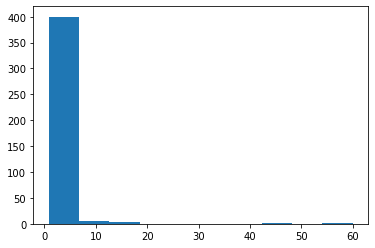

In [12]:
import matplotlib.pyplot as plt

plt.hist(mape_tmp.mean(axis=0))
plt.show()

In [13]:
(mape_tmp.mean(axis=0) < 1).mean()

0.02195121951219512

In [14]:
mape_tmp.mean(axis=0).shape

(410,)

La anterior expresión indica que únicamente en torno al 2% de las variables en X_train, tienen un error de MAPE que es inferior al 100%. 

Podíamos pensar que la primera barra en el anterior histograma esconde una gran concentración de valores con errores inferiores al 100% y que el valor final queda desviado por aquellos con valores muy superiores, sin embargo, esta última comprobación lo desmiente.

In [15]:
# ERROR SOBRE test_kaggle (no etiquetados)
test_kaggle_pred = autoencoder.predict(test_kaggle)

print("MAPE:", mape(test_kaggle, test_kaggle_pred))
print("MSE:", mse(test_kaggle, test_kaggle_pred))

MAPE: tf.Tensor(355.8933, shape=(), dtype=float32)
MSE: tf.Tensor(0.8929279, shape=(), dtype=float32)


Sobre el conjunto de entrenamiento ``test_kaggle``, vamos a seleccionar 100 veces 68 muestras y a promediar los valores de desviación típica.

In [20]:
samples_num = 100
mape_samples = []

for _ in range(samples_num):
    
    args = np.random.choice(a=np.arange(0, test_kaggle.shape[0]), size=68, replace=False)

    test_kaggle_reduc = test_kaggle[args, :]

    y_pred_kaggle_reduc = autoencoder.predict(test_kaggle_reduc)
    tmp_mape = mape(test_kaggle_reduc, y_pred_kaggle_reduc)
    mape_samples.append(tmp_mape)
    
print(f'MAPE: {np.mean(mape_samples)} +- {np.std(mape_samples)}')

MAPE: 320.42169189453125 +- 179.11102294921875


El valor del MAPE en ``test_kaggle`` es también muy elevado, con grandes desviaciones entre muestras.

Pasamos al problema de clasificación.

In [21]:
encoder_input = layers.Input(shape=(410,))
encoder = encoder_input
for layer in autoencoder.layers[1:4]:
    encoder = layer(encoder)
encoder = models.Model(inputs=encoder_input, outputs=encoder)

In [22]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 410)]             0         
                                                                 
 dense (Dense)               (None, 200)               82200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
Total params: 107,350
Trainable params: 107,350
Non-trainable params: 0
_________________________________________________________________


Una vez hemos entrenado la red autoencoder, el componente encoder de la misma ya contará con unos pesos entrenados con el objetivo de comprimir los datos de entrada. Por tanto, podemos considerar de manera independiente esta red encoder y volver a entrenarla como una red para clasificación, con la ventaja de que se parte de un modelo inicializado no con unos pesos aleatorios, sino unos pesos optimizados para un problema similar.

Para hacer esto es necesario añadir previamente una capa final de clasificación.

In [23]:
prev_encoder = encoder # loading the previously saved model.

new_encoder = models.Sequential()
new_encoder.add(prev_encoder)
new_encoder.add(layers.Dense(1, activation="sigmoid"))

Incluso es posible congelar los pesos de todas las capas del encoder original, ya entrenados "para un problema similar", y modificar solamente los pesos de la capa final de clasificación, utilizando los datos de train (etiquetados).

In [24]:
tf.keras.utils.set_random_seed(0)

# Congelar los pesos de todas las capas a excepción de la última
for layer in new_encoder.layers[:-1]:
    layer.trainable = False

# Entrenar el modelo
new_encoder.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
new_encoder.fit(X_train, y_train, epochs=100, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = new_encoder.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/100
2/2 [==============================] - 2s 169ms/step - loss: 0.7253 - acc: 0.4118 - val_loss: 0.7816 - val_acc: 0.4706
Epoch 2/100
2/2 [==============================] - 0s 33ms/step - loss: 0.7225 - acc: 0.4118 - val_loss: 0.7793 - val_acc: 0.4706
Epoch 3/100
2/2 [==============================] - 0s 32ms/step - loss: 0.7194 - acc: 0.4706 - val_loss: 0.7785 - val_acc: 0.4706
Epoch 4/100
2/2 [==============================] - 0s 32ms/step - loss: 0.7178 - acc: 0.4706 - val_loss: 0.7770 - val_acc: 0.4706
Epoch 5/100
2/2 [==============================] - 0s 56ms/step - loss: 0.7175 - acc: 0.4510 - val_loss: 0.7754 - val_acc: 0.4706
Epoch 6/100
2/2 [==============================] - 0s 62ms/step - loss: 0.7156 - acc: 0.4706 - val_loss: 0.7744 - val_acc: 0.4706
Epoch 7/100
2/2 [==============================] - 0s 42ms/step - loss: 0.7201 - acc: 0.4706 - val_loss: 0.7744 - val_acc: 0.4706
Epoch 8/100
2/2 [==============================] - 0s 29ms/step - loss: 0.7142 - acc: 0.4

2/2 [==============================] - 0s 28ms/step - loss: 0.6801 - acc: 0.5294 - val_loss: 0.7440 - val_acc: 0.4118
Epoch 64/100
2/2 [==============================] - 0s 31ms/step - loss: 0.6797 - acc: 0.5294 - val_loss: 0.7439 - val_acc: 0.4706
Epoch 65/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6784 - acc: 0.5294 - val_loss: 0.7434 - val_acc: 0.4706
Epoch 66/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6777 - acc: 0.5294 - val_loss: 0.7429 - val_acc: 0.4706
Epoch 67/100
2/2 [==============================] - 0s 25ms/step - loss: 0.6770 - acc: 0.5294 - val_loss: 0.7424 - val_acc: 0.4706
Epoch 68/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6764 - acc: 0.5490 - val_loss: 0.7420 - val_acc: 0.4706
Epoch 69/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6757 - acc: 0.5490 - val_loss: 0.7416 - val_acc: 0.4706
Epoch 70/100
2/2 [==============================] - 0s 29ms/step - loss: 0.6749 - acc: 0.5294 - 

Tras unas pocas iteraciones, descongelamos todas las capas y hacemos unas pocas épocas más entrenando y actualizando los pesos para el modelo completo.

In [25]:
tf.keras.utils.set_random_seed(0)

# Descongelar los pesos de todas las capas a excepción de la última
for layer in new_encoder.layers[:-1]:
    layer.trainable = True

# Entrenar el modelo
new_encoder.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
new_encoder.fit(X_train, y_train, epochs=15, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = new_encoder.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/15
2/2 [==============================] - 1s 145ms/step - loss: 0.6497 - acc: 0.5882 - val_loss: 0.6712 - val_acc: 0.5882
Epoch 2/15
2/2 [==============================] - 0s 30ms/step - loss: 0.4456 - acc: 0.9020 - val_loss: 0.6395 - val_acc: 0.6471
Epoch 3/15
2/2 [==============================] - 0s 30ms/step - loss: 0.3010 - acc: 1.0000 - val_loss: 0.6127 - val_acc: 0.6471
Epoch 4/15
2/2 [==============================] - 0s 28ms/step - loss: 0.1978 - acc: 1.0000 - val_loss: 0.6085 - val_acc: 0.6471
Epoch 5/15
2/2 [==============================] - 0s 28ms/step - loss: 0.1325 - acc: 1.0000 - val_loss: 0.6328 - val_acc: 0.6471
Epoch 6/15
2/2 [==============================] - 0s 26ms/step - loss: 0.0882 - acc: 1.0000 - val_loss: 0.6038 - val_acc: 0.6471
Epoch 7/15
2/2 [==============================] - 0s 29ms/step - loss: 0.0605 - acc: 1.0000 - val_loss: 0.5902 - val_acc: 0.6471
Epoch 8/15
2/2 [==============================] - 0s 35ms/step - loss: 0.0413 - acc: 1.0000 - va

In [26]:
new_encoder.save("encoder.h5")

El objetivo es poder comparar con la misma configuración de red que la encoder sin utilizar los pesos pre-entrenados de esta y observar si hay mejora.

In [27]:
tf.keras.utils.set_random_seed(0)

# Definir y entrenar el modelo
input_layer2 = layers.Input(shape=(410,))
# Capas red encoder
encoded2 = layers.Dense(200, activation="relu")(input_layer2)
encoded2 = layers.Dense(100, activation="relu")(encoded2)
encoded2 = layers.Dense(50, activation="relu")(encoded2)
encoded2 = layers.Dense(1, activation="sigmoid")(encoded2)

encoder2 = models.Model(input_layer2, encoded2)

# Entrenar el modelo
encoder2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
encoder2.fit(X_train, y_train, epochs=115, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = encoder2.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/115
2/2 [==============================] - 1s 142ms/step - loss: 0.6692 - acc: 0.6078 - val_loss: 0.6577 - val_acc: 0.7647
Epoch 2/115
2/2 [==============================] - 0s 28ms/step - loss: 0.2336 - acc: 0.9608 - val_loss: 0.6330 - val_acc: 0.8235
Epoch 3/115
2/2 [==============================] - 0s 27ms/step - loss: 0.1029 - acc: 1.0000 - val_loss: 0.6246 - val_acc: 0.8235
Epoch 4/115
2/2 [==============================] - 0s 26ms/step - loss: 0.0547 - acc: 1.0000 - val_loss: 0.6593 - val_acc: 0.8235
Epoch 5/115
2/2 [==============================] - 0s 27ms/step - loss: 0.0338 - acc: 1.0000 - val_loss: 0.6744 - val_acc: 0.8235
Epoch 6/115
2/2 [==============================] - 0s 30ms/step - loss: 0.0229 - acc: 1.0000 - val_loss: 0.6482 - val_acc: 0.7647
Epoch 7/115
2/2 [==============================] - 0s 30ms/step - loss: 0.0169 - acc: 1.0000 - val_loss: 0.6710 - val_acc: 0.7647
Epoch 8/115
2/2 [==============================] - 0s 28ms/step - loss: 0.0120 - acc: 1.0

2/2 [==============================] - 0s 26ms/step - loss: 3.2213e-06 - acc: 1.0000 - val_loss: 1.5180 - val_acc: 0.7647
Epoch 63/115
2/2 [==============================] - 0s 28ms/step - loss: 2.8532e-06 - acc: 1.0000 - val_loss: 1.5325 - val_acc: 0.7647
Epoch 64/115
2/2 [==============================] - 0s 29ms/step - loss: 2.5229e-06 - acc: 1.0000 - val_loss: 1.5448 - val_acc: 0.7647
Epoch 65/115
2/2 [==============================] - 0s 27ms/step - loss: 2.2306e-06 - acc: 1.0000 - val_loss: 1.5593 - val_acc: 0.7647
Epoch 66/115
2/2 [==============================] - 0s 24ms/step - loss: 1.9779e-06 - acc: 1.0000 - val_loss: 1.5730 - val_acc: 0.7647
Epoch 67/115
2/2 [==============================] - 0s 26ms/step - loss: 1.7591e-06 - acc: 1.0000 - val_loss: 1.5851 - val_acc: 0.7647
Epoch 68/115
2/2 [==============================] - 0s 26ms/step - loss: 1.5592e-06 - acc: 1.0000 - val_loss: 1.5968 - val_acc: 0.7647
Epoch 69/115
2/2 [==============================] - 0s 27ms/step - l

**Vamos a probar con una configuración de autoencoder más compleja**

In [28]:
tf.keras.utils.set_random_seed(0)

# Definir y entrenar el modelo
input_layer3 = layers.Input(shape=(410,))
# Capas red encoder
encoded3 = layers.Dense(300, activation="relu")(input_layer3)
encoded3 = layers.Dense(250, activation="relu")(encoded3)
encoded3 = layers.Dense(200, activation="relu")(encoded3)
encoded3 = layers.Dense(150, activation="relu")(encoded3)
encoded3 = layers.Dense(100, activation="relu")(encoded3)
encoded3 = layers.Dense(50, activation="relu")(encoded3)
# Capas red decoder
decoded3 = layers.Dense(50, activation="relu")(encoded3)
decoded3 = layers.Dense(100, activation="relu")(decoded3)
decoded3 = layers.Dense(150, activation="relu")(decoded3)
decoded3 = layers.Dense(200, activation="relu")(decoded3)
decoded3 = layers.Dense(250, activation="relu")(decoded3)
decoded3 = layers.Dense(300, activation="relu")(decoded3)
decoded3 = layers.Dense(410, activation="linear")(decoded3)

# Encoder
encoder3 = models.Model(input_layer3, encoded3)

# Autoencoder
autoencoder3 = models.Model(input_layer3, decoded3)

# Compilar y entrenar el autoencoder
autoencoder3.compile(optimizer="rmsprop", loss="mse")
autoencoder3.fit(test_kaggle, test_kaggle, epochs=200, batch_size=64, validation_split=0.25)

Epoch 1/200
1404/1404 [==============================] - 11s 7ms/step - loss: 0.9924 - val_loss: 0.9892
Epoch 2/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9837 - val_loss: 0.9809
Epoch 3/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9772 - val_loss: 0.9785
Epoch 4/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9732 - val_loss: 0.9748
Epoch 5/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9702 - val_loss: 0.9728
Epoch 6/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9683 - val_loss: 0.9725
Epoch 7/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9668 - val_loss: 0.9727
Epoch 8/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9652 - val_loss: 0.9710
Epoch 9/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9638 - val_loss: 0.9708
Epoch 10/200
1404/1404 [==============================] - 11s 8m

1404/1404 [==============================] - 11s 8ms/step - loss: 0.9442 - val_loss: 0.9632
Epoch 80/200
1404/1404 [==============================] - 11s 8ms/step - loss: 0.9441 - val_loss: 0.9628
Epoch 81/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.9441 - val_loss: 0.9628
Epoch 82/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.9441 - val_loss: 0.9636
Epoch 83/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.9440 - val_loss: 0.9624
Epoch 84/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.9440 - val_loss: 0.9636
Epoch 85/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.9439 - val_loss: 0.9634
Epoch 86/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.9439 - val_loss: 0.9623
Epoch 87/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.9440 - val_loss: 0.9633
Epoch 88/200
1404/1404 [==============================] - 12s 8ms/st

1404/1404 [==============================] - 12s 9ms/step - loss: 0.9467 - val_loss: 0.9594
Epoch 157/200
1404/1404 [==============================] - 12s 9ms/step - loss: 0.9470 - val_loss: 0.9615
Epoch 158/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.9472 - val_loss: 0.9616
Epoch 159/200
1404/1404 [==============================] - 12s 9ms/step - loss: 0.9470 - val_loss: 0.9609
Epoch 160/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.9465 - val_loss: 0.9600
Epoch 161/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.9469 - val_loss: 0.9611
Epoch 162/200
1404/1404 [==============================] - 13s 9ms/step - loss: 0.9470 - val_loss: 0.9596
Epoch 163/200
1404/1404 [==============================] - 12s 8ms/step - loss: 0.9469 - val_loss: 0.9587
Epoch 164/200
1404/1404 [==============================] - 12s 9ms/step - loss: 0.9471 - val_loss: 0.9597
Epoch 165/200
1404/1404 [==============================] - 1

In [29]:
autoencoder3.save("autoencoder3.h5")

In [30]:
# ERROR SOBRE X_train (etiquetados)
X_train_pred = autoencoder3.predict(X_train)

print("MAPE:", mape(X_train, X_train_pred))
print("MSE:", mse(X_train, X_train_pred))

MAPE: tf.Tensor(194.89369, shape=(), dtype=float32)
MSE: tf.Tensor(0.9512661, shape=(), dtype=float32)


In [31]:
# ERROR SOBRE X_train (etiquetados)
test_kaggle_pred = autoencoder3.predict(test_kaggle)

print("MAPE:", mape(test_kaggle, test_kaggle_pred))
print("MSE:", mse(test_kaggle, test_kaggle_pred))

MAPE: tf.Tensor(276.24133, shape=(), dtype=float32)
MSE: tf.Tensor(0.9518892, shape=(), dtype=float32)


En este caso, aumentar la complejidad del autoencoder apenas mejora los resultados.

Vamos a ver si se observa algún tipo de mejoría en los resultados de la red de clasificación (encoder).

In [34]:
encoder_input3 = layers.Input(shape=(410,))
encoder3 = encoder_input3
for layer in autoencoder3.layers[1:7]:
    encoder3 = layer(encoder3)
encoder3 = models.Model(inputs=encoder_input3, outputs=encoder3)

In [35]:
encoder3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 410)]             0         
                                                                 
 dense_12 (Dense)            (None, 300)               123300    
                                                                 
 dense_13 (Dense)            (None, 250)               75250     
                                                                 
 dense_14 (Dense)            (None, 200)               50200     
                                                                 
 dense_15 (Dense)            (None, 150)               30150     
                                                                 
 dense_16 (Dense)            (None, 100)               15100     
                                                                 
 dense_17 (Dense)            (None, 50)                5050

In [36]:
prev_encoder3 = encoder3 # loading the previously saved model.

new_encoder3 = models.Sequential()
new_encoder3.add(prev_encoder3)
new_encoder3.add(layers.Dense(1, activation="sigmoid"))

In [37]:
tf.keras.utils.set_random_seed(0)

# Congelar los pesos de todas las capas a excepción de la última
for layer in new_encoder3.layers[:-1]:
    layer.trainable = False

# Entrenar el modelo
new_encoder3.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
new_encoder3.fit(X_train, y_train, epochs=100, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = new_encoder3.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/100
2/2 [==============================] - 3s 639ms/step - loss: 2.9597 - acc: 0.4706 - val_loss: 3.3962 - val_acc: 0.5882
Epoch 2/100
2/2 [==============================] - 0s 72ms/step - loss: 2.8545 - acc: 0.4706 - val_loss: 3.3204 - val_acc: 0.5882
Epoch 3/100
2/2 [==============================] - 0s 33ms/step - loss: 2.7850 - acc: 0.4902 - val_loss: 3.2607 - val_acc: 0.5882
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 2.7272 - acc: 0.4902 - val_loss: 3.2058 - val_acc: 0.5882
Epoch 5/100
2/2 [==============================] - 0s 35ms/step - loss: 2.6751 - acc: 0.4706 - val_loss: 3.1561 - val_acc: 0.5882
Epoch 6/100
2/2 [==============================] - 0s 32ms/step - loss: 2.6277 - acc: 0.4706 - val_loss: 3.1090 - val_acc: 0.5882
Epoch 7/100
2/2 [==============================] - 0s 28ms/step - loss: 2.5855 - acc: 0.4314 - val_loss: 3.0588 - val_acc: 0.5882
Epoch 8/100
2/2 [==============================] - 0s 47ms/step - loss: 2.5405 - acc: 0.4

2/2 [==============================] - 0s 31ms/step - loss: 1.2240 - acc: 0.5686 - val_loss: 1.7412 - val_acc: 0.4118
Epoch 64/100
2/2 [==============================] - 0s 34ms/step - loss: 1.2057 - acc: 0.5686 - val_loss: 1.7218 - val_acc: 0.4118
Epoch 65/100
2/2 [==============================] - 0s 36ms/step - loss: 1.1874 - acc: 0.5686 - val_loss: 1.7064 - val_acc: 0.4118
Epoch 66/100
2/2 [==============================] - 0s 41ms/step - loss: 1.1715 - acc: 0.5686 - val_loss: 1.6892 - val_acc: 0.4118
Epoch 67/100
2/2 [==============================] - 0s 34ms/step - loss: 1.1563 - acc: 0.5882 - val_loss: 1.6774 - val_acc: 0.4118
Epoch 68/100
2/2 [==============================] - 0s 42ms/step - loss: 1.1400 - acc: 0.5882 - val_loss: 1.6592 - val_acc: 0.4118
Epoch 69/100
2/2 [==============================] - 0s 54ms/step - loss: 1.1227 - acc: 0.5882 - val_loss: 1.6443 - val_acc: 0.4118
Epoch 70/100
2/2 [==============================] - 0s 37ms/step - loss: 1.1054 - acc: 0.5882 - 

In [38]:
tf.keras.utils.set_random_seed(0)

# Descongelar los pesos de todas las capas a excepción de la última
for layer in new_encoder3.layers[:-1]:
    layer.trainable = True

# Entrenar el modelo
new_encoder3.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
new_encoder3.fit(X_train, y_train, epochs=15, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = new_encoder3.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/15
2/2 [==============================] - 8s 172ms/step - loss: 0.6574 - acc: 0.6275 - val_loss: 0.9287 - val_acc: 0.6471
Epoch 2/15
2/2 [==============================] - 0s 29ms/step - loss: 0.2716 - acc: 0.8824 - val_loss: 0.8215 - val_acc: 0.5294
Epoch 3/15
2/2 [==============================] - 0s 31ms/step - loss: 0.1306 - acc: 0.9804 - val_loss: 0.7821 - val_acc: 0.6471
Epoch 4/15
2/2 [==============================] - 0s 34ms/step - loss: 0.0807 - acc: 1.0000 - val_loss: 0.8131 - val_acc: 0.6471
Epoch 5/15
2/2 [==============================] - 0s 30ms/step - loss: 0.0536 - acc: 1.0000 - val_loss: 0.8580 - val_acc: 0.5882
Epoch 6/15
2/2 [==============================] - 0s 32ms/step - loss: 0.0401 - acc: 1.0000 - val_loss: 0.8129 - val_acc: 0.7059
Epoch 7/15
2/2 [==============================] - 0s 37ms/step - loss: 0.0307 - acc: 1.0000 - val_loss: 0.7860 - val_acc: 0.7059
Epoch 8/15
2/2 [==============================] - 0s 32ms/step - loss: 0.0228 - acc: 1.0000 - va

In [39]:
new_encoder3.save("encoder3.h5")

In [41]:
tf.keras.utils.set_random_seed(0)

# Definir y entrenar el modelo
input_layer4 = layers.Input(shape=(410,))
# Capas red encoder
encoded4 = layers.Dense(300, activation="relu")(input_layer4)
encoded4 = layers.Dense(250, activation="relu")(encoded4)
encoded4 = layers.Dense(200, activation="relu")(encoded4)
encoded4 = layers.Dense(150, activation="relu")(encoded4)
encoded4 = layers.Dense(100, activation="relu")(encoded4)
encoded4 = layers.Dense(50, activation="relu")(encoded4)
encoded4 = layers.Dense(1, activation="sigmoid")(encoded4)

encoder4 = models.Model(input_layer4, encoded4)

# Entrenar el modelo
encoder4.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
encoder4.fit(X_train, y_train, epochs=115, validation_split=0.25)

# Precisión en partición de test
loss, accuracy = encoder4.evaluate(X_test, y_test)
print("Accuracy: {:0.2f}%".format(accuracy * 100))

Epoch 1/115
2/2 [==============================] - 1s 158ms/step - loss: 0.6755 - acc: 0.5882 - val_loss: 0.6710 - val_acc: 0.7059
Epoch 2/115
2/2 [==============================] - 0s 32ms/step - loss: 0.3437 - acc: 0.8824 - val_loss: 0.7513 - val_acc: 0.7647
Epoch 3/115
2/2 [==============================] - 0s 29ms/step - loss: 0.0859 - acc: 0.9804 - val_loss: 1.7384 - val_acc: 0.5882
Epoch 4/115
2/2 [==============================] - 0s 29ms/step - loss: 0.2443 - acc: 0.9412 - val_loss: 0.8544 - val_acc: 0.7647
Epoch 5/115
2/2 [==============================] - 0s 31ms/step - loss: 0.0243 - acc: 1.0000 - val_loss: 0.8227 - val_acc: 0.8235
Epoch 6/115
2/2 [==============================] - 0s 29ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.8533 - val_acc: 0.8235
Epoch 7/115
2/2 [==============================] - 0s 32ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.8755 - val_acc: 0.8235
Epoch 8/115
2/2 [==============================] - 0s 32ms/step - loss: 0.0039 - acc: 1.0

2/2 [==============================] - 0s 30ms/step - loss: 4.1236e-07 - acc: 1.0000 - val_loss: 1.9559 - val_acc: 0.8235
Epoch 63/115
2/2 [==============================] - 0s 29ms/step - loss: 3.6325e-07 - acc: 1.0000 - val_loss: 1.9725 - val_acc: 0.8235
Epoch 64/115
2/2 [==============================] - 0s 29ms/step - loss: 3.2404e-07 - acc: 1.0000 - val_loss: 1.9840 - val_acc: 0.8235
Epoch 65/115
2/2 [==============================] - 0s 28ms/step - loss: 2.8882e-07 - acc: 1.0000 - val_loss: 2.0010 - val_acc: 0.8235
Epoch 66/115
2/2 [==============================] - 0s 30ms/step - loss: 2.5654e-07 - acc: 1.0000 - val_loss: 2.0178 - val_acc: 0.8235
Epoch 67/115
2/2 [==============================] - 0s 30ms/step - loss: 2.2762e-07 - acc: 1.0000 - val_loss: 2.0313 - val_acc: 0.8235
Epoch 68/115
2/2 [==============================] - 0s 28ms/step - loss: 2.0260e-07 - acc: 1.0000 - val_loss: 2.0441 - val_acc: 0.8235
Epoch 69/115
2/2 [==============================] - 0s 31ms/step - l